In [1]:

from ml_agent import TrainingParam, ReplayBuffer, DeepQAgent
from grid2op.Agent import AgentWithConverter
from grid2op.Reward import RedispReward
from grid2op.Converter import IdToAct
import numpy as np
import random
import warnings
import pdb
import grid2op
from grid2op.Reward import ConstantReward, FlatReward
from tqdm.notebook import tqdm
from grid2op.Runner import Runner
import sys
import os
import numpy as np
from grid2op.Environment import SingleEnvMultiProcess
from grid2op.Agent import DoNothingAgent


with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=FutureWarning)
    import tensorflow.keras
    import tensorflow.keras.backend as K
    from tensorflow.keras.models import load_model, Sequential, Model
    from tensorflow.keras.optimizers import Adam
    from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, subtract, add
    from tensorflow.keras.layers import Input, Lambda, Concatenate

In [2]:
class TrainAgentMultiEnv(object):
    def __init__(self, agent, nb_process, reward_fun=RedispReward, env=None, name=None):
        # compare to the version showed in the notebook 3, the process buffer has been moved in this class
        # and we add a multi_envs argument.
        self.nb_process = nb_process
        self.multi_envs = None
        self.process_buffer = [[] for _ in range(self.nb_process)]
        self.name = name
        self.agent = agent
        self.env = env
        self.training_param = None
    
    def close(self):
        self.multi_envs.close()
        
    def convert_process_buffer(self):
        """
        Converts the list of NUM_FRAMES images in the process buffer
        into one training sample
        这里观察了NUM_FRAMES段时间，然后预测下一个时间的动作
        """
        # here i simply concatenate the action in case of multiple action in the "buffer"
        if self.training_param.NUM_FRAMES != 1:
            raise RuntimeError("This has not been tested with self.training_param.NUM_FRAMES != 1 for now")
        return np.array([np.concatenate(el) for el in self.process_buffer])
        
    def _build_valid_env(self, training_param):
        # this function has also be adapted
        create_new = False
        if self.multi_envs is None:
            create_new = True
            # first we need to initialize the multi environment
            self.multi_envs = SingleEnvMultiProcess(env=env, nb_env=self.nb_process)
            
            # then, as before, we reset it
            obss = self.multi_envs.reset()
            for worker_id in range(self.nb_process):
                self.process_buffer[worker_id].append(self.agent.convert_obs(obss[worker_id]))
                
            # used in case of "num frames" != 1 (so not tested)
            do_nothing = [self.env.action_space() for _ in range(self.nb_process)]
            for _ in range(training_param.NUM_FRAMES-1):
                # Initialize buffer with the first frames
                s1, r1, _, _ = self.multi_envs.step(do_nothing)
                for worker_id in range(self.nb_process):
                    # difference compared to previous implementation: we loop through all the observations
                    # and save them all
                    self.process_buffer[worker_id].append(self.agent.convert_obs(s1[worker_id])) 
                    
        return create_new
    
    def train(self, num_frames, training_param=TrainingParam()):
        """
        
        :param num_frames: 总训练轮数
        :param training_param: 
        :return: 
        """
        self.training_param = training_param
        
        # first we create an environment or make sure the given environment is valid
        close_env = self._build_valid_env(training_param)
        
        # same as in the original implemenation, except the process buffer is now in this class
        observation_num = 0
        curr_state = self.convert_process_buffer()  #初始化的observation
        
        # we initialize the NN exactly as before
        self.agent.init_deep_q(curr_state)
            
        epsilon = training_param.INITIAL_EPSILON
        # now the number of alive frames and total reward depends on the "underlying environment". It is vector instead
        # of scalar
        alive_frame = np.zeros(self.nb_process, dtype=np.int)
        total_reward = np.zeros(self.nb_process, dtype=np.float)

        with tqdm(total=num_frames) as pbar:    #生成进度条
            while observation_num < num_frames:
                if observation_num % 1000 == 999:
                    print(("Executing loop %d" %observation_num))
                    # for efficient reading of data: at early stage of training, it is advised to load
                    # data by chunk: the model will do game over pretty easily (no need to load all the dataset)
                    tmp = min(10000 * (num_frames // observation_num), 10000)
                    self.multi_envs.set_chunk_size(int(max(100, tmp)))

                # Slowly decay the learning rate
                if epsilon > training_param.FINAL_EPSILON:
                    epsilon -= (training_param.INITIAL_EPSILON-training_param.FINAL_EPSILON)/training_param.EPSILON_DECAY

                initial_state = self.convert_process_buffer()
                self.process_buffer = [[] for _ in range(self.nb_process)]

                # TODO vectorize that in the Agent directly
                # then we need to predict the next moves. Agents have been adapted to predict a batch of data
                pm_i, pq_v = self.agent.deep_q.predict_movement(curr_state, epsilon)
                # pm_i：动作编号   pq_v ：动作价值   神经网络的model,传几条数据就会出几个结果，不需要对multienvs专门处理
                
                # and build the convenient vectors (it was scalars before)
                predict_movement_int = []
                predict_q_value = []
                acts = []
                for p_id in range(self.nb_process):
                    predict_movement_int.append(pm_i[p_id])
                    predict_q_value.append(pq_v[p_id])
                    # and then we convert it to a valid action
                    acts.append(self.agent.convert_act(pm_i[p_id]))

                # same loop as in notebook 3
                reward, done = np.zeros(self.nb_process), np.full(self.nb_process, fill_value=False, dtype=np.bool)
                for i in range(training_param.NUM_FRAMES):
                    temp_observation_obj, temp_reward, temp_done, _ = self.multi_envs.step(acts)

                    # we need to handle vectors for "done"
                    reward[~temp_done] += temp_reward[~temp_done]
                    # and then "de stack" the observations coming from different environments
                    for worker_id, obs in enumerate(temp_observation_obj):
                        self.process_buffer[worker_id].append(self.agent.convert_obs(temp_observation_obj[worker_id])) 
                    done = done | temp_done

                    # increase of 1 the number of frame alive for relevant "underlying environments"
                    # 看活跃的environment能进行多少时间段
                    alive_frame[~temp_done] += 1
                    # loop through the environment where a game over was done, and print the results
                    #打印结束的环境编号
                    for env_done_idx in np.where(temp_done)[0]:
                        print("For env with id {}".format(env_done_idx))
                        print("\tLived with maximum time ", alive_frame[env_done_idx])
                        print("\tEarned a total of reward equal to ", total_reward[env_done_idx])

                    # NB注意 BaseMultiProcessEnvironment.step() 当done=True时，会自动调用reset()
                    reward[temp_done] = 0.
                    total_reward[temp_done] = 0.    #将异常结束的环境，reward和total_reward置为0，惩罚很严重
                    total_reward += reward
                    alive_frame[temp_done] = 0      #将异常结束的环境，alive_frame置为0，惩罚很严重

                # vectorized version of the previous code
                new_state = self.convert_process_buffer()
                # same as before, but looping through the "underlying environment"
                for sub_env_id in range(self.nb_process):
                    self.agent.replay_buffer.add(initial_state[sub_env_id],
                                                 predict_movement_int[sub_env_id],
                                                 reward[sub_env_id],
                                                 done[sub_env_id],
                                                 new_state[sub_env_id])

                if self.agent.replay_buffer.size() > training_param.MIN_OBSERVATION:
                    s_batch, a_batch, r_batch, d_batch, s2_batch = self.agent.replay_buffer.sample(training_param.MINIBATCH_SIZE)
                    isfinite = self.agent.deep_q.train(s_batch, a_batch, r_batch, d_batch, s2_batch, observation_num)
                    self.agent.deep_q.target_train()

                    if not isfinite:
                        # if the loss is not finite i stop the learning
                        print("ERROR INFINITE LOSS")
                        break


                # Save the network every 10000 iterations
                if observation_num % 10000 == 9999 or observation_num == num_frames-1:
                    print("Saving Network")
                    if self.name is None:
                        self.agent.deep_q.save_network("saved_notebook6.h5")
                    else:
                        self.agent.deep_q.save_network("saved_notebook6_{}".format(self.name))

                observation_num += 1
                pbar.update(1)
            
        if close_env:
            print("closing env")
            self.env.close()


In [3]:
env = grid2op.make("rte_case14_realistic", test=True)
TRAINING_STEP = 70
NUM_CORE = 6
agent_name = "DQN_1e5"
my_agent = DeepQAgent(env.action_space, mode="DQN", training_param=TrainingParam())
trainer = TrainAgentMultiEnv(agent=my_agent, env=env, nb_process=NUM_CORE, name=agent_name)
# trainer = TrainAgent(agent=my_agent, env=env)
trainer.train(TRAINING_STEP)
trainer.close()


C:\sofeware_install\Anaconda3\lib\site-packages\grid2op\MakeEnv\Make.py:269: UserWarning: You are using a development environment. This environment is not intended for training agents. It might not be up to date and its primary use if for tests (hence the "test=True" you passed as argument). Use at your own risk.
  warnings.warn(_MAKE_DEV_ENV_WARN)


q_actions[0, opt_policy]:{}} [-0.24244401 -0.24244401 -0.24244401 -0.24244401 -0.24244401  0.04614154]
For env with id 0
	Lived with maximum time  0
	Earned a total of reward equal to  0.0
For env with id 1
	Lived with maximum time  0
	Earned a total of reward equal to  0.0
For env with id 2
	Lived with maximum time  0
	Earned a total of reward equal to  0.0
For env with id 3
	Lived with maximum time  0
	Earned a total of reward equal to  0.0
For env with id 4
	Lived with maximum time  0
	Earned a total of reward equal to  0.0
For env with id 5
	Lived with maximum time  0
	Earned a total of reward equal to  0.0
q_actions[0, opt_policy]:{}} [-0.24244401  0.1827291   0.02310767 -0.24244401 -0.24244401 -0.24244401]
For env with id 0
	Lived with maximum time  0
	Earned a total of reward equal to  0.0
For env with id 1
	Lived with maximum time  0
	Earned a total of reward equal to  0.0
For env with id 3
	Lived with maximum time  0
	Earned a total of reward equal to  0.0
For env with id 4
	L

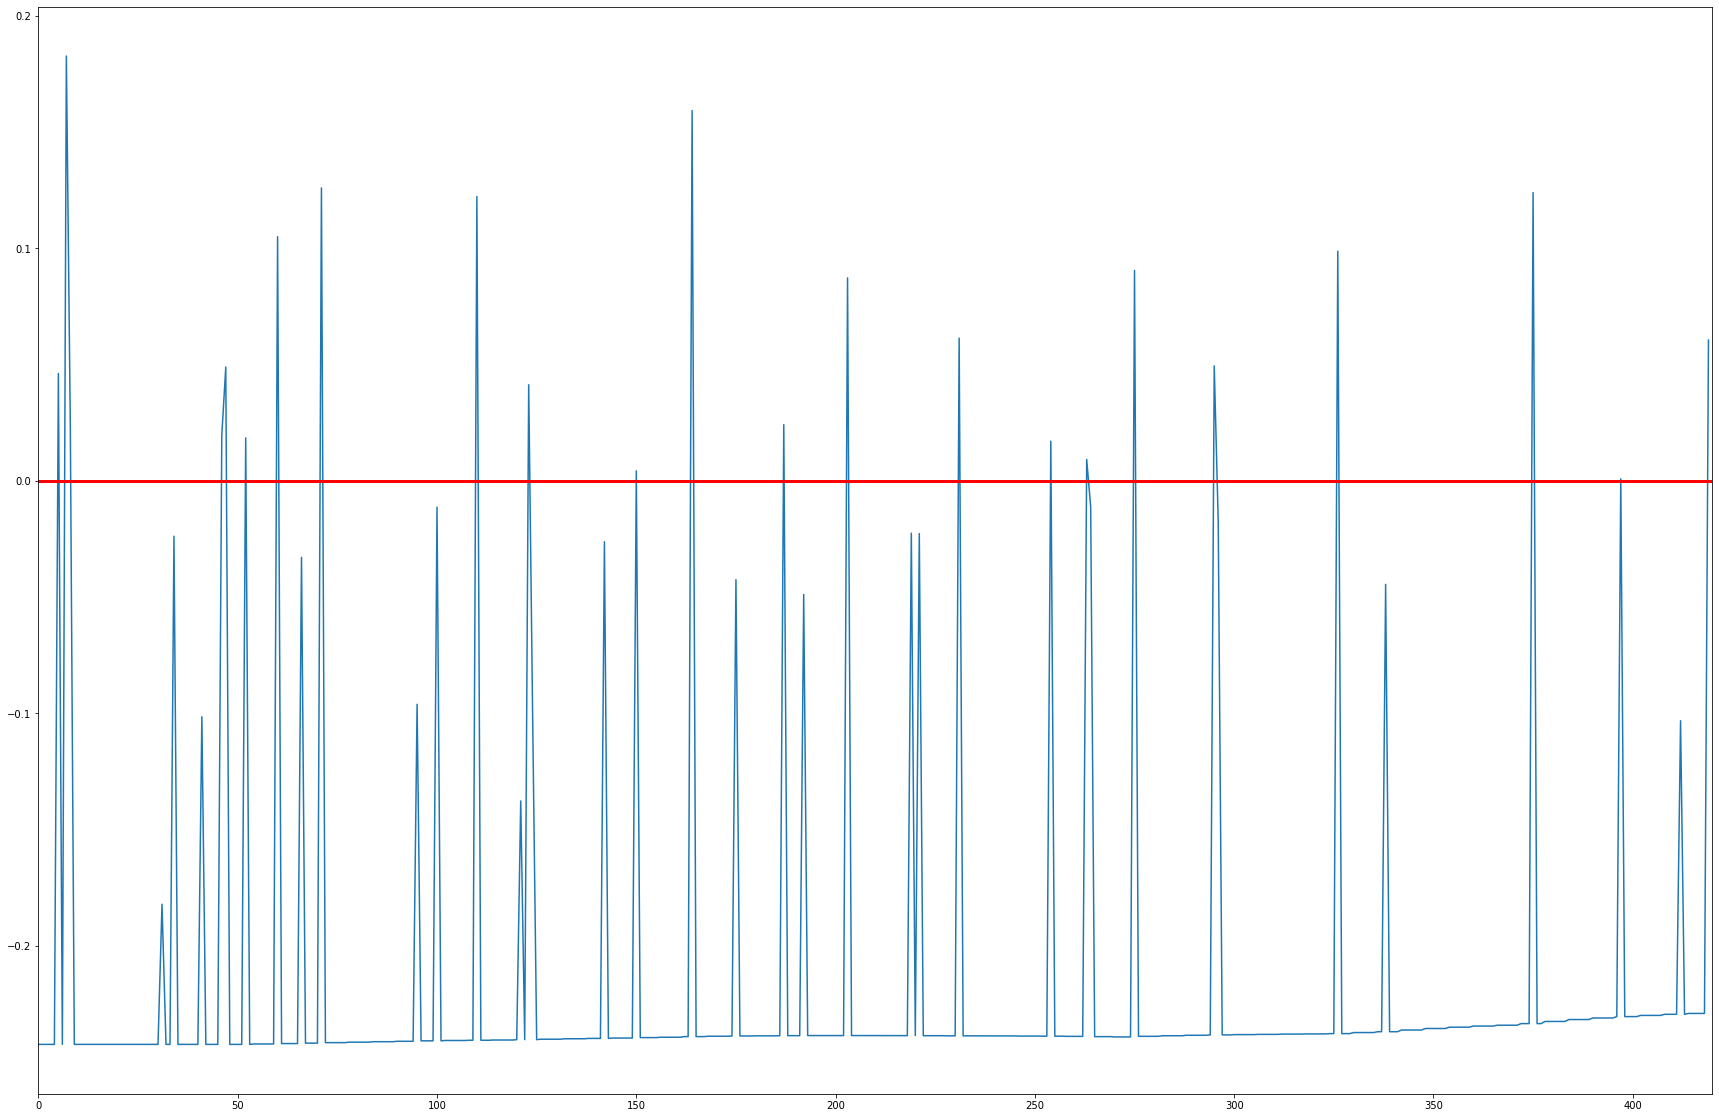

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(30,20))
plt.plot(my_agent.deep_q.qvalue_evolution)
plt.axhline(y=0, linewidth=3, color='red')
_ = plt.xlim(0, len(my_agent.deep_q.qvalue_evolution))

In [5]:
# NB_EPISODE = 2
# max_iter = 10000
# # tun the do nothing for the whole episode
# dn_agent = grid2op.Agent.DoNothingAgent(env.action_space)
# runner = Runner(**env.get_params_for_runner(), agentInstance=dn_agent, agentClass=None)
# res = runner.run(nb_episode=NB_EPISODE, max_iter=max_iter, pbar=tqdm)
# print("The results for the DoNothing agent are:")
# for _, chron_id, cum_reward, nb_time_step, max_ts in res:
#     msg_tmp = "\tFor chronics with id {}\n".format(chron_id)
#     msg_tmp += "\t\t - cumulative reward: {:.6f}\n".format(cum_reward)
#     msg_tmp += "\t\t - number of time steps completed: {:.0f} / {:.0f}".format(nb_time_step, max_ts)
#     print(msg_tmp)

In [6]:
# env = grid2op.make("rte_case14_realistic", test=True)
# obs = env.reset()
# trained_agent = DeepQAgent(env.action_space, mode="DDQN", training_param=TrainingParam())
# trained_agent.init_deep_q(trained_agent.convert_obs(obs))
# trained_agent.load_network("saved_notebook6_{}".format(agent_name))
# runner = Runner(**env.get_params_for_runner(),
#                 agentInstance=trained_agent, agentClass=None)
# res = runner.run(nb_episode=NB_EPISODE,
#                  max_iter=max_iter, pbar=tqdm)
# print("The results for the DoNothing agent are:")
# for _, chron_id, cum_reward, nb_time_step, max_ts in res:
#     msg_tmp = "\tFor chronics with id {}\n".format(chron_id)
#     msg_tmp += "\t\t - cumulative reward: {:.6f}\n".format(cum_reward)
#     msg_tmp += "\t\t - number of time steps completed: {:.0f} / {:.0f}".format(nb_time_step, max_ts)
#     print(msg_tmp)
